In [4]:
import results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

sns.set(style = "whitegrid", rc = {
   "legend.frameon": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Lucida Grande",
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.labelsize": 16,
    'legend.fontsize': 12,
    'legend.title_fontsize': 'large'
})
palette = sns.color_palette(['#0072BB', '#937860', '#4E148C', '#00916E', '#000000', '#EE6123','#FF6123' ])

## Combined convergence plot

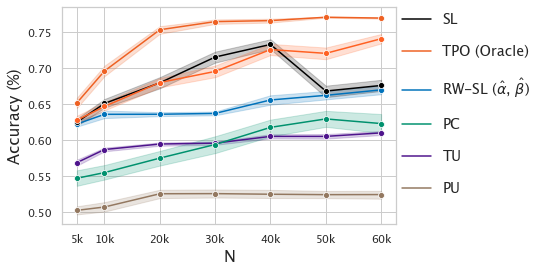

In [5]:
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
oracle_df, _ = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_oracle_R10')

learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)

oracle_baselines = ['Target Oracle', 'RW-SL', 'COM', 'COM-SL', 'OBS Oracle', 'OBS']
oracle_df = oracle_df[oracle_df['baseline'].isin(oracle_baselines)]
baselines_df = pd.concat([learn_df, oracle_df])
baselines_df.reset_index(inplace=True)

baselines_df = baselines_df[baselines_df['alpha_0'] != 0.2]
n_baselines = len(baselines_df['baseline'].unique())


# baselines_df = baselines_df[baselines_df['alpha_0'] == 0.4]

fig = sns.lineplot(
    palette=palette[:n_baselines],
    data=baselines_df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')
fig.set_xlabel('N')
fig.set_ylabel('Accuracy (%)')

disp_names = {
    'Target Oracle': 'TPO (Oracle)',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'PC',
    'COM-SL': 'SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'TU',
    'OBS': 'PU',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'COM-SL ($\hat{\alpha}$, $\hat{\beta}$)'
}

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 5,0,3,2,1]
plt.legend([handles[idx] for idx in order],[disp_names[labels[idx]] for idx in order],
           bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0., fontsize='large', labelspacing=1.25)

fig.set_xticks([5000, 10000, 20000, 30000, 40000, 50000, 60000], labels=['5k', '10k', '20k', '30k', '40k', '50k', '60k'])
plt.savefig('figs/convergence_plot.png', dpi=500, bbox_inches = "tight")



## Generate table across error rate configurations

In [59]:
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL', 'COM-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].unique()

pd.options.display.float_format = "{:,.2f}".format
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
oracle_df, _ = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_oracle_R10')

learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL', 'COM-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)

oracle_baselines = ['Target Oracle', 'RW-SL', 'COM-SL', 'COM', 'OBS Oracle', 'OBS']
oracle_df = oracle_df[oracle_df['baseline'].isin(oracle_baselines)]
baselines_df = pd.concat([learn_df, oracle_df])
baselines_df.reset_index(inplace=True)

baselines_df['param'] = "(" + baselines_df['alpha_0'].astype(str)+"," +baselines_df['beta_0'].astype(str) + ")"

# Mean dataframe
table_df = baselines_df[baselines_df['NS'] == 60000][['baseline', 'param', 'ACC']].groupby(['baseline', 'param']).mean().reset_index()
mean_df = pd.pivot_table(table_df, values='ACC', index=['baseline'], columns=['param'])
lst = ["OBS", "OBS Oracle", "COM", "COM-SL (learned)", "COM-SL",  "RW-SL (learned)","RW-SL", "Target Oracle"]
mean_df = mean_df.loc[lst]
mean_df = 100*mean_df

# # Se dataframe
table_df =  baselines_df[baselines_df['NS'] == 60000][['baseline', 'param', 'ACC']].groupby(['baseline', 'param']).sem().reset_index()
sem_df = pd.pivot_table(table_df, values='ACC', index=['baseline'], columns=['param'])
lst = ["OBS", "OBS Oracle", "COM", "COM-SL (learned)", "COM-SL",  "RW-SL (learned)","RW-SL", "Target Oracle"]
sem_df = sem_df.loc[lst]
sem_df = 100*sem_df

for col in mean_df:
    mean_df[col] = mean_df[col].apply(lambda x: '{0:.2f}'.format(x))
    sem_df[col] = sem_df[col].apply(lambda x: '{0:.2f}'.format(x))
    mean_df[col] = mean_df[col].astype(str).map(str) + " (" + sem_df[col].astype(str) + ")"

print(mean_df.to_latex())


## Experimental study dataset results

In [4]:
def get_ate_result_df(exp_name):
    # NR_erm_ohie_crossfit_oracle_params_R10
    results = []
    for f in glob.glob(f'results/{exp_name}/*TE.csv'):
        results.append(pd.read_csv(f))
    nsdf = pd.concat(results)
    nsdf.drop(columns=['Unnamed: 0'], inplace=True)
    nsdf['param'] = "(" + nsdf['alpha_0'].astype(str)+"," +nsdf['beta_0'].astype(str) + ")"
    nsdf['ate_error'] = nsdf['ate'] - nsdf['ate_hat'] 
    return nsdf

def filter_baselines(df, include_baselines):
    include_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
    df = df[df['baseline'].isin(include_baselines)]
    return df.reset_index()
      

In [62]:
jdf_learned = get_ate_result_df('main_table_jobs_learned').reset_index()

jdf_learned.groupby(['param']).mean()

,index,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,alpha_1_hat,beta_1_hat,NS,...,prw_0.4,pr_0.4,prw_0.45,pr_0.45,prw_0.5,pr_0.5,prw_0.55,pr_0.55,prw_0.6,pr_0.6
param,,,,,,,,,,,,,,,,,,,,,
"(0.0,0.4)",14.50,0.00,0.00,0.40,0.00,0.00,0.52,0.26,0.53,NaN,...,0.52,0.22,0.53,0.22,0.53,0.22,0.53,0.22,0.53,0.22
"(0.1,0.3)",14.50,0.10,0.00,0.30,0.00,0.01,0.43,0.26,0.52,NaN,...,0.54,0.23,0.54,0.23,0.55,0.23,0.55,0.23,0.55,0.23
"(0.2,0.2)",14.50,0.20,0.00,0.20,0.00,0.05,0.21,0.10,0.58,NaN,...,0.56,0.23,0.56,0.23,0.56,0.23,0.56,0.23,0.56,0.23
"(0.3,0.1)",14.50,0.30,0.00,0.10,0.00,0.10,0.12,0.06,0.57,NaN,...,0.51,0.21,0.51,0.21,0.51,0.21,0.51,0.21,0.51,0.21
"(0.4,0.0)",14.50,0.40,0.00,0.00,0.00,0.21,0.04,0.10,0.57,NaN,...,0.53,0.22,0.53,0.22,0.53,0.22,0.53,0.22,0.53,0.22


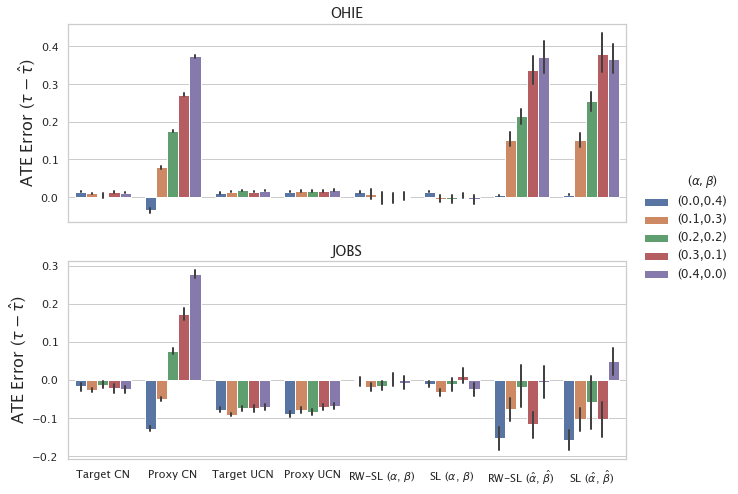

In [63]:
odf_oracle = get_ate_result_df('A_main_experiment_ohie_oracle_R10').reset_index()
jdf_oracle = get_ate_result_df('A_main_experiment_jobs_oracle_R10').reset_index()
odf_learned = get_ate_result_df('main_table_ohie_learned_crossfit').reset_index()
jdf_learned = get_ate_result_df('main_table_jobs_learned').reset_index()

# Load learned baselines
learned_baselines = ['RW-SL (learned)', 'COM-SL (learned)']
odf_learned['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
odf_learned['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)
odf_learned = odf_learned[odf_learned['baseline'].isin(learned_baselines)]

jdf_learned['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
jdf_learned['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)
jdf_learned = jdf_learned[jdf_learned['baseline'].isin(learned_baselines)]

# Oracle baselines
include_baselines = ['Target Oracle', 'COM', 'OBS Oracle', 'OBS', 'RW-SL', 'COM-SL']
odf_oracle = odf_oracle[odf_oracle['baseline'].isin(include_baselines)]
jdf_oracle = jdf_oracle[jdf_oracle['baseline'].isin(include_baselines)]

ohie_df = pd.concat([odf_learned, odf_oracle]).sort_values(by=['baseline', 'alpha_0'], ascending=True)
jobs_df = pd.concat([jdf_learned, jdf_oracle]).sort_values(by=['baseline', 'alpha_0'], ascending=True)

disp_names = {
    'Target Oracle': 'Target CN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': r'SL ($\alpha$, $\beta$)',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)',
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
g = sns.barplot(data=ohie_df, x='baseline', y='ate_error', hue='param',
                order=include_baselines + learned_baselines, ci=68, errwidth=2, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
ax1.set_title('OHIE')
g.legend().set_visible(False)

g = sns.barplot(data=jobs_df, x='baseline',y='ate_error',hue='param',
                ci=68, errwidth=2, ax=ax2, order=include_baselines + learned_baselines)
plt.xlabel("")
ax2.set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
ax2.set_title('JOBS')
ax2.legend( title=r"         ($\alpha, \beta$)", bbox_to_anchor=(1.2, 1.5))


# handles, labels = plt.gca().get_legend_handles_labels()
labels = [disp_names[item.get_text()] for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)

plt.savefig('figs/tau_bias.png', dpi=500, bbox_inches = "tight")



### Final plot including oracle and learned parameters

In [224]:
odf_oracle = get_ate_result_df('A_main_experiment_ohie_oracle_R10').reset_index()
jdf_oracle = get_ate_result_df('A_main_experiment_jobs_oracle_R10').reset_index()
odf_learned = get_ate_result_df('A_assumptions_experiment_ohie_learn_R10').reset_index()
jdf_learned = get_ate_result_df('A_assumptions_experiment_jobs_learn_R10').reset_index()


# Learned baselines
plot_assumptions = ['weak_seperability', 'baserate_min_anchor', 'baserate_max_anchor']
odf_learned = odf_learned[odf_learned['assumption'].isin(plot_assumptions) & (odf_learned['baseline'] == 'RW-SL')]
odf_learned = odf_learned.sort_values(by=['assumption', 'alpha_0'], ascending=True)
jdf_learned = jdf_learned[jdf_learned['assumption'].isin(plot_assumptions) & (jdf_learned['baseline'] == 'RW-SL')]
jdf_learned = jdf_learned.sort_values(by=['assumption', 'alpha_0'], ascending=True)


# Oracle baselines
oracle_baselines = [ 'COM', 'OBS Oracle', 'OBS', 'COM-SL', 'RW-SL', 'Target Oracle']
odf_oracle = odf_oracle[odf_oracle['baseline'].isin(oracle_baselines)]
jdf_oracle = jdf_oracle[jdf_oracle['baseline'].isin(oracle_baselines)]
odf_oracle = odf_oracle.sort_values(by=['baseline', 'alpha_0'], ascending=True)
jdf_oracle = jdf_oracle.sort_values(by=['baseline', 'alpha_0'], ascending=True)

baseline_names = {
    'Target Oracle': 'TC',
    'RW-SL': r'RW-SL',
    'COM': 'PC',
    'COM-SL': r'SL',
    'OBS Oracle': 'TU',
    'OBS': 'PU',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)',
}

assumption_names = {
    'weak_seperability': r'Max/Min',
    'baserate_max_anchor': 'Br/Max',
    'baserate_min_anchor': r'Br/Min',
}

In [225]:
baseline_names

{'Target Oracle': 'TC',
 'RW-SL': 'RW-SL',
 'COM': 'PC',
 'COM-SL': 'SL',
 'OBS Oracle': 'TU',
 'OBS': 'PU',
 'RW-SL (learned)': 'RW-SL ($\\hat{\\alpha}$, $\\hat{\\beta}$)',
 'COM-SL (learned)': 'SL ($\\hat{\\alpha}$, $\\hat{\\beta}$)'}

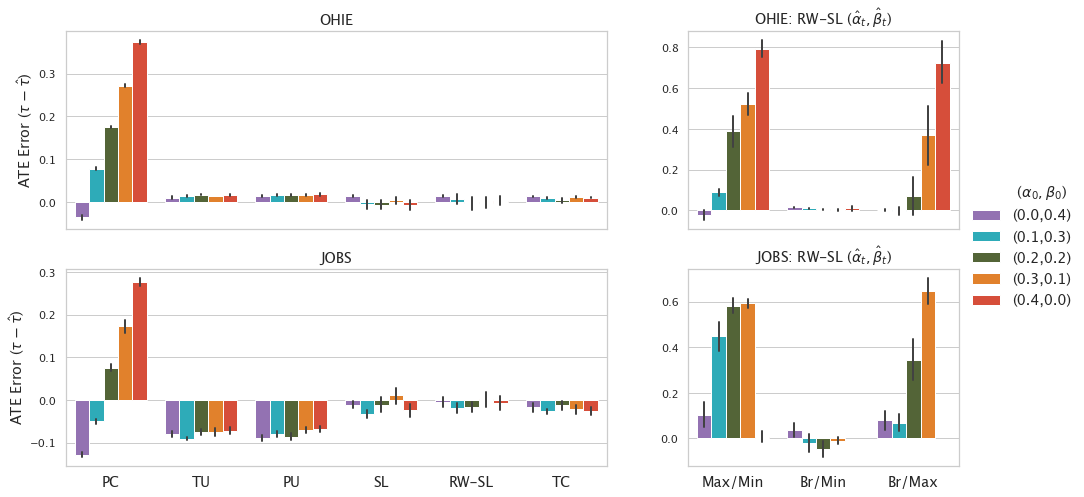

In [226]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), sharex='col', gridspec_kw={'width_ratios':[2,1]})
palette = sns.color_palette(['#9467bd', '#17becf',  '#556b2f', '#ff7f0e','#f03b20'])

# OHIE benchmark with oracle parameters
g = sns.barplot(data=odf_oracle, x='baseline', y='ate_error', hue='param', palette=palette[:len(oracle_baselines)],
                order=oracle_baselines, ci=68, errwidth=2, ax=axs[0,0])
axs[0,0].set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)', fontsize='large')
axs[0,0].set_title('OHIE', fontsize='large')
g.legend().set_visible(False)
axs[0,0].set_xlabel("")


# JOBS benchmark with oracle parameters
g = sns.barplot(data=jdf_oracle, x='baseline',y='ate_error',hue='param', palette=palette[:len(oracle_baselines)],
                ci=68, errwidth=2, ax=axs[1,0], order=oracle_baselines)
g.legend().set_visible(False)
axs[1,0].set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)', fontsize='large')
axs[1,0].set_title('JOBS', fontsize='large')
axs[1,0].set_xlabel("")

labels = [baseline_names[item.get_text()] for item in axs[1,0].get_xticklabels()]
axs[1,0].set_xticklabels(labels, fontsize='large')


# OHIE benchmark with learned parameters
g = sns.barplot(data=odf_learned, x='assumption',y='ate_error',hue='param', palette=palette[:len(oracle_baselines)],
                ci=68, errwidth=2, ax=axs[0,1], order=plot_assumptions)

axs[0,1].set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
axs[0,1].set_title(r'OHIE: RW-SL ($\hat{\alpha}_t, \hat{\beta}_t$)', fontsize='large')
axs[0,1].legend( title=r"         ($\alpha_0, \beta_0$)", bbox_to_anchor=(1, 0.3), fontsize='large')
axs[0,1].set_xlabel("")
axs[0,1].set_ylabel("")


# JOBS benchmark with learned parameters
g = sns.barplot(data=jdf_learned, x='assumption',y='ate_error',hue='param', palette=palette[:len(oracle_baselines)],
                ci=68, errwidth=2, ax=axs[1,1], order=plot_assumptions)
g.legend().set_visible(False)
axs[1,1].set_title(r'JOBS: RW-SL ($\hat{\alpha}_t, \hat{\beta}_t$)', fontsize='large')
axs[1,1].set_xlabel("")
axs[1,1].set_ylabel("")

labels = [assumption_names[item.get_text()] for item in axs[1,1].get_xticklabels()]
axs[1,1].set_xticklabels(labels, fontsize='large')



plt.savefig('figs/tau_bias.png', dpi=500, bbox_inches = "tight")


In [ ]:
### odf_oracle = get_ate_result_df('A_main_experiment_ohie_oracle_R10').reset_index()
odf_learned = get_ate_result_df('main_table_ohie_learned_crossfit').reset_index()
jdf_oracle = get_ate_result_df('A_main_experiment_jobs_oracle_R10').reset_index()
jdf_learned = get_ate_result_df('main_table_jobs_learned').reset_index()


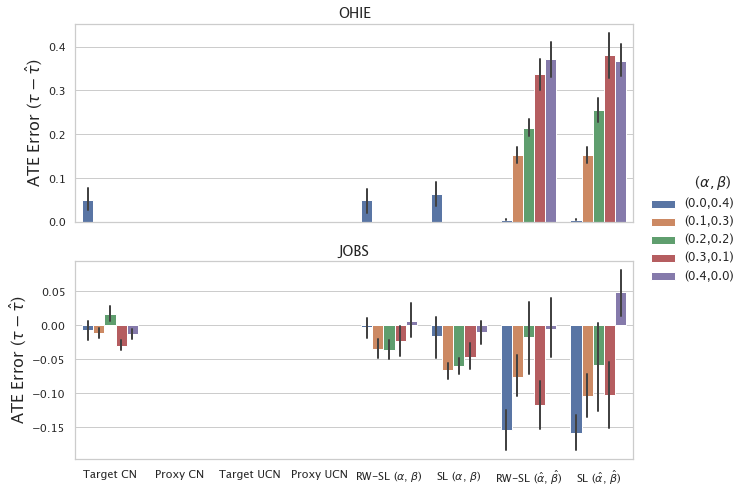

In [222]:
odf_oracle = get_ate_result_df('ATE_RERUN_ohie_crossfit_oracle_R10').reset_index()
odf_learned = get_ate_result_df('main_table_ohie_learned_crossfit').reset_index()
jdf_oracle = get_ate_result_df('ATE_RERUN_jobs_crossfit_oracle_R10').reset_index()
jdf_learned = get_ate_result_df('main_table_jobs_learned').reset_index()

# Load learned baselines
learned_baselines = ['RW-SL (learned)', 'COM-SL (learned)']
odf_learned['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
odf_learned['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)
odf_learned = odf_learned[odf_learned['baseline'].isin(learned_baselines)]


jdf_learned['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
jdf_learned['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)
jdf_learned = jdf_learned[jdf_learned['baseline'].isin(learned_baselines)]


# Oracle baselines
include_baselines = ['Target Oracle', 'COM', 'OBS Oracle', 'OBS', 'RW-SL', 'COM-SL']
odf_oracle = odf_oracle[odf_oracle['baseline'].isin(include_baselines)]
jdf_oracle = jdf_oracle[jdf_oracle['baseline'].isin(include_baselines)]

ohie_df = pd.concat([odf_learned, odf_oracle]).sort_values(by=['baseline', 'alpha_0'], ascending=True)
jobs_df = pd.concat([jdf_learned, jdf_oracle]).sort_values(by=['baseline', 'alpha_0'], ascending=True)

disp_names = {
    'Target Oracle': 'Target CN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': r'SL ($\alpha$, $\beta$)',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)',
}


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
g = sns.barplot(data=ohie_df, x='baseline', y='ate_error', hue='param',
                order=include_baselines + learned_baselines, ci=68, errwidth=2, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
ax1.set_title('OHIE')
g.legend().set_visible(False)

g = sns.barplot(data=jobs_df, x='baseline',y='ate_error',hue='param',
                ci=68, errwidth=2, ax=ax2, order=include_baselines + learned_baselines)
plt.xlabel("")
ax2.set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
ax2.set_title('JOBS')
ax2.legend( title=r"         ($\alpha, \beta$)", bbox_to_anchor=(1.2, 1.5))


# handles, labels = plt.gca().get_legend_handles_labels()
labels = [disp_names[item.get_text()] for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)

plt.savefig('figs/tau_bias.png', dpi=500, bbox_inches = "tight")


In [374]:
jdf_oracle = get_ate_result_df('ATE_RERUN_jobs_crossfit_oracle_R10').reset_index()
jdf_oracle[jdf_oracle['baseline'] == 'COM-SL'].groupby(['param']).mean()['ate_error']

param
(0.0,0.4)   -0.029218
(0.1,0.3)   -0.037846
(0.2,0.2)   -0.059685
(0.3,0.1)   -0.046127
(0.4,0.0)   -0.031888
Name: ate_error, dtype: float64

## Analysis of error parameter estimates

In [22]:
# learn_df = get_ate_result_df('WS_debug')
# learn_df['alpha_0_error'] = learn_df['alpha_0'] - learn_df['alpha_0_hat']
# learn_df['beta_0_error'] = learn_df['beta_0'] - learn_df['beta_0_hat']
# learn_df['alpha_1_error'] = learn_df['alpha_1'] - learn_df['alpha_1_hat']
# learn_df['beta_1_error'] = learn_df['beta_1'] - learn_df['beta_1_hat']

# learn_df = learn_df[learn_df['baseline'] == 'RW-SL']
# learn_df['param'] = "(" + learn_df['alpha_0'].astype(str)+"," + learn_df['beta_0'].astype(str) + ")"


learn_df = get_ate_result_df('WS_debug')
learn_df['eta_0_min'] = learn_df['alpha_0_hat']
learn_df['eta_0_max'] = 1-learn_df['beta_0_hat']
learn_df['eta_1_min'] = learn_df['alpha_1_hat']
learn_df['eta_1_max'] = 1-learn_df['beta_1_hat']

In [27]:
print(learn_df[learn_df['benchmark'] == 'ohie']['eta_0_min'].mean())
print(learn_df[learn_df['benchmark'] == 'ohie']['eta_1_min'].mean())

print(learn_df[learn_df['benchmark'] == 'ohie']['eta_0_max'].mean())
print(learn_df[learn_df['benchmark'] == 'ohie']['eta_1_max'].mean())

2.233274093110804e-06
1.0276527208452624e-05
0.8558575704693794
0.8137190595269204


In [21]:
learn_df[learn_df['benchmark'] == 'jobs']

,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,alpha_1_hat,beta_1_hat,benchmark,assumption,...,prw_0.55,pr_0.55,prw_0.6,pr_0.6,baseline,param,eta_0_min,eta_0_max,eta_1_min,eta_1_max
0,0.0,0,0.0,0,0.002318,0.905488,0.046601,0.428912,jobs,weak_seperability,...,0.742267,0.280488,0.742267,0.280488,RW-SL,"(0.0,0.0)",0.002318,0.094512,0.046601,0.571088
1,0.0,0,0.0,0,0.000367,0.972459,0.035154,0.426366,jobs,weak_seperability,...,0.487122,0.206522,0.487122,0.206522,RW-SL,"(0.0,0.0)",0.000367,0.027541,0.035154,0.573634
2,0.0,0,0.0,0,0.000537,0.925095,0.004383,0.339907,jobs,weak_seperability,...,0.645833,0.250000,0.645833,0.250000,RW-SL,"(0.0,0.0)",0.000537,0.074905,0.004383,0.660093
3,0.0,0,0.0,0,0.005304,0.966183,0.074287,0.458509,jobs,weak_seperability,...,0.461484,0.195652,0.461484,0.195652,RW-SL,"(0.0,0.0)",0.005304,0.033817,0.074287,0.541491
4,0.0,0,0.0,0,0.000602,0.916085,0.052002,0.518879,jobs,weak_seperability,...,0.372704,0.149425,0.372704,0.149425,RW-SL,"(0.0,0.0)",0.000602,0.083915,0.052002,0.481121
5,0.0,0,0.0,0,0.004083,0.928392,0.198390,0.421974,jobs,weak_seperability,...,0.448347,0.181818,0.448347,0.181818,RW-SL,"(0.0,0.0)",0.004083,0.071608,0.198390,0.578026
6,0.0,0,0.0,0,0.002315,0.986050,0.048840,0.427199,jobs,weak_seperability,...,0.575306,0.235955,0.575306,0.235955,RW-SL,"(0.0,0.0)",0.002315,0.013950,0.048840,0.572801
7,0.0,0,0.0,0,0.000403,0.921102,0.062799,0.431528,jobs,weak_seperability,...,0.602151,0.258065,0.602151,0.258065,RW-SL,"(0.0,0.0)",0.000403,0.078898,0.062799,0.568472
8,0.0,0,0.0,0,0.003482,0.906458,0.053008,0.426380,jobs,weak_seperability,...,0.707341,0.273810,0.707341,0.273810,RW-SL,"(0.0,0.0)",0.003482,0.093542,0.053008,0.573620
9,0.0,0,0.0,0,0.001463,0.915926,0.091737,0.456351,jobs,weak_seperability,...,0.520515,0.213483,0.520515,0.213483,RW-SL,"(0.0,0.0)",0.001463,0.084074,0.091737,0.543649


In [26]:
print(learn_df[learn_df['benchmark'] == 'jobs']['eta_0_min'].min())
print(learn_df[learn_df['benchmark'] == 'jobs']['eta_1_min'].min())

print(learn_df[learn_df['benchmark'] == 'jobs']['eta_0_max'].max())
print(learn_df[learn_df['benchmark'] == 'jobs']['eta_1_max'].max())

0.0003670835285447
0.0043831481598317
0.09451216459274281
0.6600925028324127


In [6]:

# learn_df = get_ate_result_df('Z_ohie_learned_param_debug')
# learn_df = get_ate_result_df('NATE_erm_ohie_crossfit_learned_R10_00')

# learn_df.groupby(['param', 'NS'])['alpha_0_error', 'beta_0_error'].mean()
# sns.barplot(data=learn_df, x="NS", y="alpha_0_error", hue='param', ci=68, marker='o')

In [231]:
learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_72965/2504277234.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()


,eta_0_min,eta_0_max,eta_1_min,eta_1_max
param,,,,
"(0.0,0.4)",0.02,0.48,0.06,0.76
"(0.1,0.3)",0.09,0.53,0.07,0.73
"(0.2,0.2)",0.16,0.60,0.07,0.75
"(0.3,0.1)",0.30,0.90,0.00,1.00
"(0.4,0.0)",0.38,0.63,0.07,0.76


In [26]:
# learn_df.groupby(['param'])['alpha_0_hat', 'beta_0_hat', 'alpha_1_hat', 'beta_1_hat'].mean()
# OHIE
learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_72965/2223583362.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()


,eta_0_min,eta_0_max,eta_1_min,eta_1_max
param,,,,
"(0.0,0.4)",0.019804,0.484671,0.058406,0.759415
"(0.1,0.3)",0.090551,0.531339,0.074742,0.728594
"(0.2,0.2)",0.155127,0.599263,0.071552,0.754364
"(0.3,0.1)",0.268058,0.597882,0.078028,0.745685
"(0.4,0.0)",0.381248,0.626773,0.069657,0.756901


In [249]:
alpha = 0.2
beta = 0.3

ci_s = .2
cj_s = .8

ci = (1-beta)*ci_s + alpha*(1-ci_s)
cj = (1-beta)*cj_s + alpha*(1-cj_s)

alpha_hat = (ci_s*cj- ci*cj_s)/(ci_s-cj_s)
beta_hat = (ci*cj_s-ci+ci_s-cj_s+cj-ci_s*cj)/(ci_s-cj_s)


In [250]:
alpha_hat = (ci - (1-beta)*ci_s)/(1-ci_s)
alpha_hat

0.20000000000000007

<AxesSubplot:xlabel='assumption', ylabel='ate_error'>

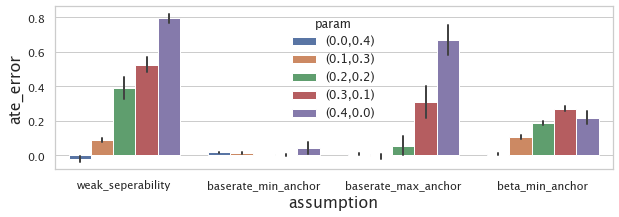

In [29]:
pedf = get_ate_result_df('A_assumptions_experiment_ohie_learn_R10').reset_index()

assumptions = ['weak_seperability', 'baserate_min_anchor', 'baserate_max_anchor','beta_min_anchor']


pedf = pedf.sort_values(by=['baseline', 'alpha_0'], ascending=True)
plt.figure(figsize=(10,3))

sns.barplot(data=pedf, x='assumption', y='ate_error', hue='param', ci=68, errwidth=2)



In [435]:
pedf = get_ate_result_df('A_assumptions_experiment_jobs_learn_R10').reset_index()
pedf[pedf['beta_0_hat'] < 0]




,index,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,alpha_1_hat,beta_1_hat,benchmark,...,prw_0.45,pr_0.45,prw_0.5,pr_0.5,prw_0.55,pr_0.55,prw_0.6,pr_0.6,baseline,param
100,20,0.3,0,0.1,0,0.178720,-0.007097,0.033855,0.179434,jobs,...,0.745409,0.298851,0.745409,0.298851,0.745409,0.298851,0.745409,0.298851,COM-SL,"(0.3,0.1)"
101,21,0.3,0,0.1,0,0.178720,-0.007097,0.033855,0.179434,jobs,...,0.745409,0.298851,0.745409,0.298851,0.745409,0.298851,0.745409,0.298851,RW-SL,"(0.3,0.1)"
102,22,0.3,0,0.1,0,0.061244,-0.234654,0.007953,0.024388,jobs,...,0.509012,0.211111,0.509012,0.211111,0.509012,0.211111,0.509012,0.211111,COM-SL,"(0.3,0.1)"
103,23,0.3,0,0.1,0,0.061244,-0.234654,0.007953,0.024388,jobs,...,0.509012,0.211111,0.509012,0.211111,0.509012,0.211111,0.509012,0.211111,RW-SL,"(0.3,0.1)"
104,24,0.3,0,0.1,0,0.051016,-0.291109,0.062185,0.171923,jobs,...,0.553571,0.214286,0.553571,0.214286,0.553571,0.214286,0.553571,0.214286,COM-SL,"(0.3,0.1)"
105,25,0.3,0,0.1,0,0.051016,-0.291109,0.062185,0.171923,jobs,...,0.553571,0.214286,0.553571,0.214286,0.553571,0.214286,0.553571,0.214286,RW-SL,"(0.3,0.1)"
106,26,0.3,0,0.1,0,0.130887,-0.233517,0.003208,0.008116,jobs,...,0.645833,0.250000,0.645833,0.250000,0.645833,0.250000,0.645833,0.250000,COM-SL,"(0.3,0.1)"
107,27,0.3,0,0.1,0,0.130887,-0.233517,0.003208,0.008116,jobs,...,0.645833,0.250000,0.645833,0.250000,0.645833,0.250000,0.645833,0.250000,RW-SL,"(0.3,0.1)"
108,28,0.3,0,0.1,0,0.005037,-0.653608,0.010463,0.022156,jobs,...,0.586804,0.232558,0.586804,0.232558,0.586804,0.232558,0.586804,0.232558,COM-SL,"(0.3,0.1)"
109,29,0.3,0,0.1,0,0.005037,-0.653608,0.010463,0.022156,jobs,...,0.586804,0.232558,0.586804,0.232558,0.586804,0.232558,0.586804,0.232558,RW-SL,"(0.3,0.1)"


<AxesSubplot:>

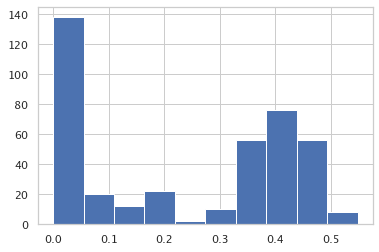

In [434]:
pedf['beta_1_hat'].hist()

In [176]:
# OHIE
learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_16218/2488721978.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()


,eta_0_min,eta_0_max,eta_1_min,eta_1_max
param,,,,
"(0.0,0.0)",1.000000e-09,0.002588,1.000000e-09,0.011487
"(0.0,0.4)",1.000000e-09,0.030648,1.000000e-09,0.054081
"(0.1,0.3)",3.574930e-05,0.460925,1.337465e-09,0.071308
"(0.2,0.2)",6.369805e-05,0.562086,1.000000e-09,0.048681
"(0.3,0.1)",5.754529e-04,0.746939,1.000000e-09,0.044414
"(0.4,0.0)",2.831854e-03,0.971088,1.006524e-09,0.062590


In [341]:
def generate_ohie_data(OHIE_PATH, error_params, train_ratio=.7, shuffle=True):
    
    ohie_df = pd.read_csv(OHIE_PATH)
    
    YS = ohie_df[['Y']].squeeze()
    D = ohie_df[['D']].squeeze()
    ohie_df.drop(columns=['Y', 'D'], inplace=True)

    YS_0 = np.zeros_like(YS)
    YS_1 = np.zeros_like(YS)

    YS_0[D==0] = YS[D==0]
    YS_1[D==1] = YS[D==1]

    Y_0 = YS_0.copy()
    Y_1 = YS_1.copy()
    Y = np.zeros_like(YS)
    
    alpha_0_errors = np.random.binomial(1, error_params['alpha_0'], size=ohie_df.shape[0])
    alpha_1_errors = np.random.binomial(1, error_params['alpha_1'], size=ohie_df.shape[0])
    beta_0_errors = np.random.binomial(1, error_params['beta_0'], size=ohie_df.shape[0])
    beta_1_errors = np.random.binomial(1, error_params['beta_1'], size=ohie_df.shape[0])

    Y_0[(Y_0 == 0) & (alpha_0_errors == 1)] = 1
    Y_0[(Y_0 == 1) & (beta_0_errors == 1)] = 0
    Y_1[(Y_1 == 0) & (alpha_1_errors == 1)] = 1
    Y_1[(Y_1 == 1) & (beta_1_errors == 1)] = 0

    Y[D==0] = Y_0[D==0]
    Y[D==1] = Y_1[D==1]

    dataset_y = {
        'YS': YS,
        'YS_0': YS_0,
        'YS_1': YS_1,
        'Y_0': Y_0,
        'Y_1': Y_1,
        'Y': Y,
        'pD': np.ones_like(D) * D.mean(),
        'pD_hat': np.ones_like(D) * D.mean(),
        'D': D,
        'E': np.ones_like(YS) # Include for computing the ATT on JOBS test data
    }

    X, Y = pd.DataFrame(ohie_df), pd.DataFrame(dataset_y)

    print(Y['YS'].mean())

    if shuffle: 
        suffle_ix = permutation(X.index)
        X = X.iloc[suffle_ix]
        Y = Y.iloc[suffle_ix]

    split_ix = int(X.shape[0]*train_ratio)
    X_train = X[:split_ix]
    X_test = X[split_ix:]
    Y_train = Y[:split_ix]
    Y_test = Y[split_ix:]

    #Selection bias: medicare opportunity not provided to individuals above the federal poverty line
    X_train_s = X_train[(Y_train['D'].to_numpy() == 0) |
        ((Y_train['D'].to_numpy() == 1) & (X_train['above_federal_pov'].to_numpy() == 0))]

    Y_train_s = Y_train[(Y_train['D'] == 0).to_numpy() | 
        ((Y_train['D'] == 1).to_numpy() & (X_train['above_federal_pov'] == 0).to_numpy())]  


    X_train_s = (X_train_s - X_train_s.mean(axis=0))/X_train_s.std(axis=0)
    X_test = (X_test - X_train_s.mean(axis=0))/X_train_s.std(axis=0)

    print(Y_train_s['YS'].mean())
    print(Y_test['YS'].mean())

    return X_train_s, X_test, Y_train_s, Y_test

In [347]:
from attrdict import AttrDict
import numpy as np
import pandas as pd
from numpy.random import permutation
from data import loaders

error_params = AttrDict({
    'alpha_0': 0.0,
    'alpha_1': 0.0,
    'beta_0': 0.0,
    'beta_1': 0.0,
})

X_train_s, X_test, Y_train_s, Y_test = generate_ohie_data("data/OHIE/ohie_data.csv",
                                                          error_params, train_ratio=.7, shuffle=True)



0.09512082499615207
0.0873523622047244
0.10002564760194922


## Gamma plot  

In [11]:
jobs_df = get_ate_result_df('main_table_jobs_oracle')

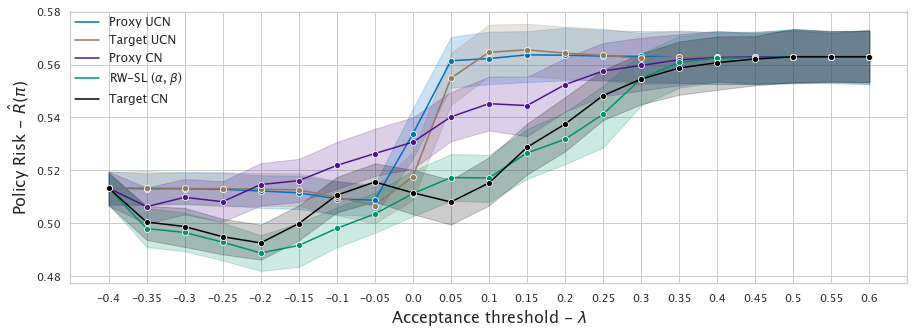

In [9]:
jobs_df = get_ate_result_df('main_table_jobs_oracle')
jobs_df.rename(columns={'pr_-4':'pr_-.4'}, inplace=True)
pg_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
gamma_settings = [i for i in jobs_df if 'pr_' in i][1:]
disp_gamma = gamma_settings[::2]
# gamma_settings[0] = 'pr_-.4'
# jobs_df = jobs_df[jobs_df['alpha_0'] != .2]


pr_results = ['baseline'] + gamma_settings
disp_names = {
    'Target Oracle': 'Target CN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': 'COM-SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'SL' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)'
}

gammadf = jobs_df[pr_results].melt(id_vars=['baseline'], var_name="gamma", value_name='policy_risk')
gammadf = gammadf[gammadf['baseline'].isin(pg_baselines)]


plt.figure(figsize=(15,5))
fig = sns.lineplot(data=gammadf, x='gamma', hue='baseline', y='policy_risk',
                   marker='o', ci=68, palette=palette[:len(pg_baselines)])


plt.xlabel('Acceptance threshold - $\lambda$')
plt.ylabel('Policy Risk - $\hat{R}(\pi)$')
fig.set_xticks([i for i in range(len(gamma_settings))], labels=[float(i.split('_')[1]) for i in gamma_settings])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([h for h in handles],[disp_names[label] for label in labels], loc='best', borderaxespad=0., fontsize='medium')

# JOBS data

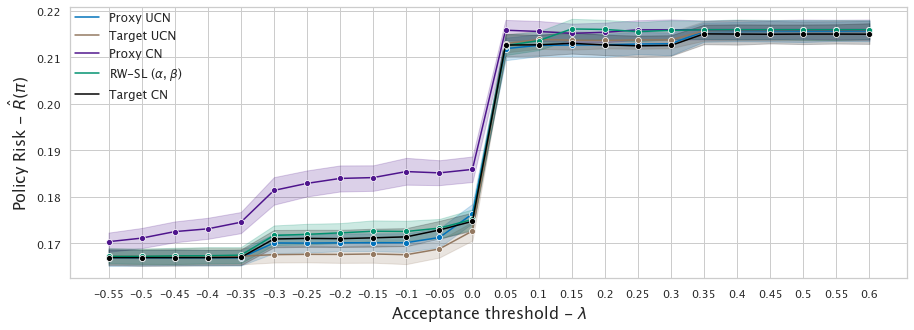

In [36]:
#OHIE plot

## Plots with 

In [7]:
def plot_experimental_data_results(df, metric):
    plt.figure(figsize=(12, 6))
    g = sns.barplot(data=df, x='baseline', y=metric, hue='param', ci=68, errwidth=2)
    plt.xlabel("")
    
    ylabel = "MSE ATE" if metric == "ate_error" else "Policy Risk"
    
    plt.ylabel(ylabel)
    plt.legend( title=r"         ($\alpha, \beta$)")
#     models = ['X -> Y', 'X,T->Y (RW-SL)', 'X->$Y_t$* (Target Oracle)','X->Y*', 'X,T->Y', 'X,T->Y (SL)', 'X,T->Y (RW)', 'X->$Y_t$ (Proxy Oracle)']
#     g.set_xticks(range(len(models)), models, size=12)
#     plt.xticks(rotation=45)


plot_experimental_data_results(ohie, 'ate_error')

NameError: name 'ohie' is not defined

In [35]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data=jobs, x='baseline', y="pr_0.2", ci=68, errwidth=2, capsize=.05)

plt.ylabel("Policy risk")


NameError: name 'jobs' is not defined

<Figure size 864x432 with 0 Axes>

In [71]:
# results/main_table_ohie_learned_crossfit

learn = pd.read_csv('results/main_table_jobs_learned/runs=10_epochs=20_alpha=0.4_beta=0.0_TE.csv')



In [74]:
learn[['alpha_0','alpha_0_hat','beta_0','beta_0_hat','alpha_1','alpha_1_hat','beta_1','beta_1_hat']]

,alpha_0,alpha_0_hat,beta_0,beta_0_hat,alpha_1,alpha_1_hat,beta_1,beta_1_hat
0,0.4,0.212896,0.0,0.015439,0,0.054855,0,0.606340
1,0.4,0.212896,0.0,0.015439,0,0.054855,0,0.606340
2,0.4,0.212896,0.0,0.015439,0,0.054855,0,0.606340
3,0.4,0.281029,0.0,0.037167,0,0.305402,0,0.518423
4,0.4,0.281029,0.0,0.037167,0,0.305402,0,0.518423
5,0.4,0.281029,0.0,0.037167,0,0.305402,0,0.518423
6,0.4,0.255162,0.0,0.085431,0,0.209944,0,0.545950
7,0.4,0.255162,0.0,0.085431,0,0.209944,0,0.545950
8,0.4,0.255162,0.0,0.085431,0,0.209944,0,0.545950
9,0.4,0.193129,0.0,0.050098,0,0.053716,0,0.605259
